In [1]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [2]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [3]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# hide
from pathlib import Path, PosixPath
from typing import Union

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio.mask
from rasterio.io import DatasetReader
from rasterio.plot import show
from shapely.geometry import Polygon

from geowrangler import grids

/home/butchtm/work/geomaint/wrkwrangler/.venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Raster Processing Tutorial

> A basic introduction to raster processing

## Summary
Cropping rasters based on the borders of a polygon. Usage of this function assumes an input raster and a geodataframe from which to extract bounds. There is also an option to crop multiple geometries at once (e.g., crop raster using bounds of each cell in a grid). 

## How does it work? 


Returns a subset of a rasterio dataset. This function assumes that the bounding coordinates for the desired cropped rasters are present in the input geodataframe's *geometry* column. 



### `query_window_by_polygon(raster, output_folder, gdf, mask)`
**For cropping a raster based on boundaries of a single polygon.** A technical step-by-step explanation of how `query_window_by_polygon` works is detailed in the cell blocks below.

| | type | default | optional/ required | details |
| --- | :--- | :--- | :--- | :--- |
| raster | String | *none* | required | local filename of raster or open raster dataset |
| output_folder | String | *none* | required | file path where cropped raster outputs will be saved | 
| gdf | GeoDataFrame | *none* | required | polygon that will become basis of boundaries for cropping |
| mask | Boolean | *none* | required | *True*- Assign NULL to areas outside borders of a non-rectangular polygon \ *False*- Retain values outside borders of a non-rectangular polygon |

1) Define the function and its arguments.

```
def query_window_by_polygon(
    input_raster: Union[str, DatasetReader, PosixPath],
    output_path: str,
    geometry: Polygon,
    mask=False,
) -> None:
```

2) Check if raster is specified as PosixPath and convert to String. 

```
    if isinstance(input_raster, PosixPath):
        input_raster = str(input_raster)
```

3) Check if raster is path to a file or an open raster dataset.

```
    if isinstance(input_raster,str):
         input_dset = rio.open(input_raster)
    else:
         input_dset = input_raster
```

4) Get the window bounds (left, right, top, bottom coordinates) from polygon geometry and check if it has the correct number of elements.

```
    window_bounds = geometry.bounds
    assert (
        len(window_bounds) == 4
    ), 
```

5) Unroll window bounds.

```
    left, bottom, right, top = window_bounds
```

6) Open raster as input.

```
    with rio.open(input_raster) as input_dst:
```

7) Get profile of *input_dst*:

```
        input_profile = input_dst.profile
```

8) Specify window and query subset.

```
        window = rio.windows.from_bounds(left, bottom, right, top, input_dst.transform)
        subset = input_dst.read(window=window)
```

9) Get the shape of the output subset.

```
        number_of_bands, height, width = subset.shape
```

10) Get the transformation of the subset based on the window.

```
        win_transform = input_dst.window_transform(window)
```

11) Update metadata for the output.

```
        output_profile = input_profile.copy()
        update_params = {
            "count": number_of_bands,
            "height": height,
            "width": width,
            "transform": win_transform,
        }
        output_profile.update(update_params)
```

12) Write image to output file.

```
        with rio.open(output_path, "w", **output_profile) as output_dst:
            output_dst.write(subset)
            output_dst.colorinterp = input_dst.colorinterp
```

13) Apply mask according to shape of the polygon. 

```
    if mask:
        with rio.open(output_path) as dst:
            masked_image, masked_transform = rio.mask.mask(dst, [geometry], crop=True)
        with rio.open(output_path, "w", **output_profile) as output_dst:
            update_params = {
                "height": masked_image.shape[1],
                "width": masked_image.shape[2],
                "transform": masked_transform,
            }
            output_profile.update(update_params)
            output_dst.write(masked_image)
```

14) Return output.

```
    return 
```

### `query_window_by_gdf(raster, output_folder, gdf, name_col, mask)`
**For cropping a raster based on boundaries of multiple polygons.** A step-by-step explanation of how `query_window_by_gdf` works is detailed in the cell blocks below.

| | type | default | optional/ required | details |
| --- | :--- | :--- | :--- | :--- |
| raster | String | *none* | required | local filename of raster or open raster dataset |
| output_folder | String | *none* | required | file path where cropped raster outputs will be saved | 
| gdf | GeoDataFrame | *none* | required | polygon that will become basis of boundaries for cropping |
| name_col | String | *none* | optional |  column name to base output filepath on. if left blank, outputs will be name sequentially as 'output_0.tif' | 
| mask | Boolean | *none* | required | *True*- Assign NULL to areas outside borders of a non-rectangular polygon \ *False*- Retain values outside borders of a non-rectangular polygon |

1) Define the function and create a copy of the geodataframe.

```
def query_window_by_gdf(
    input_raster: Union[str, DatasetReader, PosixPath],
    output_folder: str,
    gdf,
    name_col=None,
    mask=False,
) -> None:
    gdf = gdf.copy()
```

2. Check if the coordinate reference systems of the raster and geodataframe match.

```
    with rio.open(input_raster) as dst:
        assert dst.meta["crs"] == gdf.crs, "input_raster and gdf CRS must match!"
```

3) Name outputs based on values from *name_col*.

```
    if name_col is None:
        name_col = "name"
        gdf[name_col] = "output_" + gdf.reset_index().index.astype(str) + ".tif"
    else:
        gdf[name_col] = gdf[name_col] + ".tif"

    for i, row in gdf.iterrows():
        polygon = row.geometry
        output_name = row[name_col]
        output_path = output_folder / output_name
        print(output_path)
        query_window_by_polygon(input_raster, output_path, polygon, mask)
```

## Sample use case 1- Crop raster with single circular polygon

Input:
- `input_image` - raster of 2020 Philippine population
- `output_folder` - filepath to where output raster will be saved
- `circle_gdf` - GeoDataFrame containining single circular polygon
- `mask` - *True*- to assign NULL values to cells outside the circular polygon

Output:
- cropped raster (GeoTiff) containing only values within circular polygon

In [5]:
# hide

import warnings

from IPython.display import display

warnings.filterwarnings("ignore", category=UserWarning, module="geopandas")

### Step 1: Import packages

In [6]:
# hide
from pathlib import Path, PosixPath
from typing import Union

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio.mask
from rasterio.io import DatasetReader
from rasterio.plot import show
from shapely.geometry import Polygon

from geowrangler import grids

In [7]:
import rasterio as rio

import geowrangler.raster_process as raster_process

### Step 2: Load raster

In [8]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/phl_ppp_2020_constrained.tif ] && curl -s -o ../data/phl_ppp_2020_constrained.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_ppp_2020_constrained.tif

In [9]:
# hide
input_image = "../data/phl_ppp_2020_constrained.tif"

In [10]:
input_image

'../data/phl_ppp_2020_constrained.tif'

In [11]:
raster = rio.open(input_image)

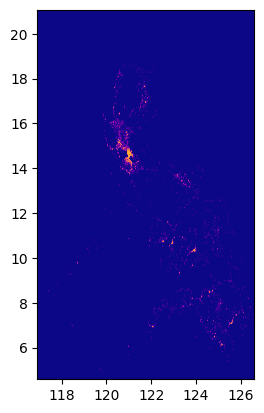

In [12]:
# no_test
show(raster.read(1), cmap="plasma", transform=raster.transform);

### Step 3: Load polygon

In [13]:
# hide
def make_circle_geometry(lat, lon, buffer, crs="epsg:4326"):
    df = pd.DataFrame({"lat": [lat], "lon": [lon]})
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=crs)
    gdf["geometry"] = gdf["geometry"].buffer(buffer)
    return gdf


circle_gdf = make_circle_geometry(14.599512, 120.984222, 1)

/tmp/ipykernel_78748/1091849391.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = gdf["geometry"].buffer(buffer)


In [14]:
circle_gdf

,lat,lon,geometry
0,14.599512,120.984222,"POLYGON ((121.98422 14.59951, 121.97941 14.501..."


### Step 4: Check if the polygon is within bounds of the raster.

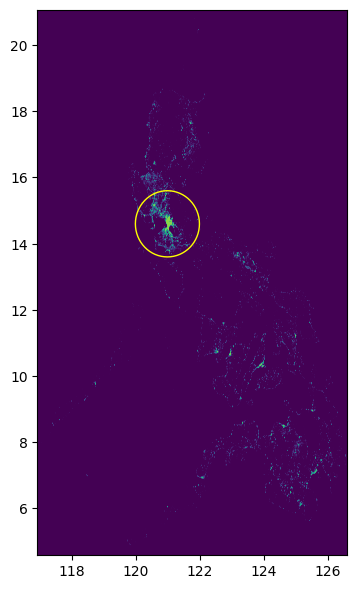

In [15]:
# no_test
fig, ax = plt.subplots(1, 1, figsize=(4, 8))
show(raster.read(1), cmap="viridis", ax=ax, transform=raster.transform)
circle_gdf.plot(ax=ax, facecolor="none", edgecolor="yellow")
ax;

### Step 5: State filepath of output folder.

In [16]:
output_folder = Path("../data")

### Step 6: Crop raster

In [17]:
# no_test
raster_process.query_window_by_gdf(input_image, output_folder, circle_gdf, mask=True)

../data/output_0.tif


[[-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 ...
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]
 [-99999. -99999. -99999. ... -99999. -99999. -99999.]]


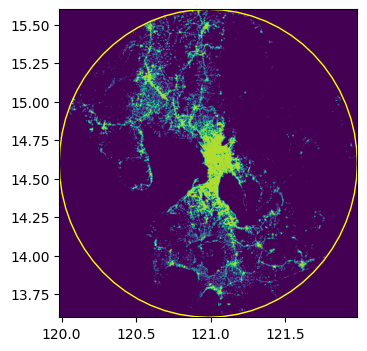

In [18]:
# no_test
with rio.open(output_folder / "output_0.tif") as dst:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    show(dst.read(1), cmap="viridis", ax=ax, transform=dst.transform)
    circle_gdf.plot(facecolor="none", edgecolor="yellow", ax=ax)
    print(dst.read(1))
ax;

## Sample use case 2- Crop raster with multiple cells from a grid

Input:
- `input_image` - raster of 2020 Philippine population
- `output_folder` - filepath to where output rasters will be saved
- `grid_gdf` - GeoDataFrame containining multiple polygons (grid cells)
- `mask` - *False*- no need to assign NULL values because grid cells occupy full space from image center to boundaries

Output:
- multiple cropped rasters (GeoTiff) split according to grid cell polygons

### Step 1: Import packages

In [19]:
# hide
# no_test
from pathlib import Path, PosixPath
from typing import Union

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio.mask
from rasterio.io import DatasetReader
from rasterio.plot import show
from shapely.geometry import Polygon

from geowrangler import grids

In [20]:
import rasterio as rio

import geowrangler.raster_process

### Step 2: Load raster

In [21]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/phl_ppp_2020_constrained.tif ] && curl -s -o ../data/phl_ppp_2020_constrained.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_ppp_2020_constrained.tif

In [22]:
# hide
input_image = "../data/phl_ppp_2020_constrained.tif"

In [23]:
input_image

'../data/phl_ppp_2020_constrained.tif'

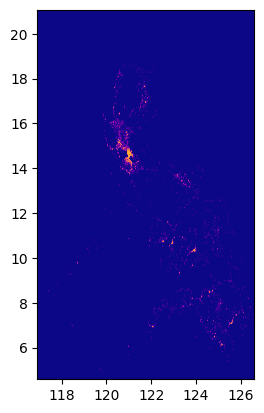

<AxesSubplot:>

In [24]:
# no_test
raster = rio.open(input_image)
show(raster.read(1), cmap="plasma", transform=raster.transform)

### Step 3: Load grid

In [25]:
# hide
grid_generator = grids.SquareGridGenerator(100_000)
grid_gdf = grid_generator.generate_grid(circle_gdf)
grid_gdf["name"] = (
    "gridxy-" + grid_gdf["x"].astype(str) + "-" + grid_gdf["y"].astype(str)
)

In [26]:
# no_test
grid_gdf

,x,y,geometry,name
0,0,0,"POLYGON ((119.98422 13.59951, 120.88254 13.599...",gridxy-0-0
1,0,1,"POLYGON ((119.98422 14.47100, 120.88254 14.471...",gridxy-0-1
2,0,2,"POLYGON ((119.98422 15.33908, 120.88254 15.339...",gridxy-0-2
3,1,0,"POLYGON ((120.88254 13.59951, 121.78085 13.599...",gridxy-1-0
4,1,1,"POLYGON ((120.88254 14.47100, 121.78085 14.471...",gridxy-1-1
5,1,2,"POLYGON ((120.88254 15.33908, 121.78085 15.339...",gridxy-1-2
6,2,0,"POLYGON ((121.78085 13.59951, 122.67917 13.599...",gridxy-2-0
7,2,1,"POLYGON ((121.78085 14.47100, 122.67917 14.471...",gridxy-2-1


### Step 4: Check if the grid is within bounds of the raster.

<AxesSubplot:>

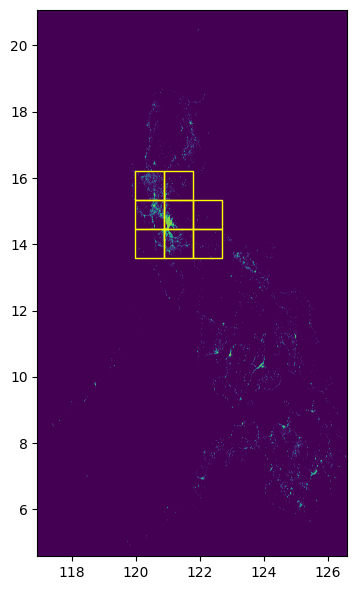

In [27]:
# no_test
fig, ax = plt.subplots(1, 1, figsize=(4, 8))
show(raster.read(1), cmap="viridis", ax=ax, transform=raster.transform)
grid_gdf.plot(ax=ax, facecolor="none", edgecolor="yellow")
ax

### Step 5: State filepath of output folder.

In [28]:
# no_test
output_folder = Path("../data")

### Step 6: Crop raster

In [29]:
# no_test
raster_process.query_window_by_gdf(
    input_image, output_folder, grid_gdf, name_col="name", mask=False
)

../data/gridxy-0-0.tif
../data/gridxy-0-1.tif
../data/gridxy-0-2.tif
../data/gridxy-1-0.tif
../data/gridxy-1-1.tif
../data/gridxy-1-2.tif
../data/gridxy-2-0.tif
../data/gridxy-2-1.tif


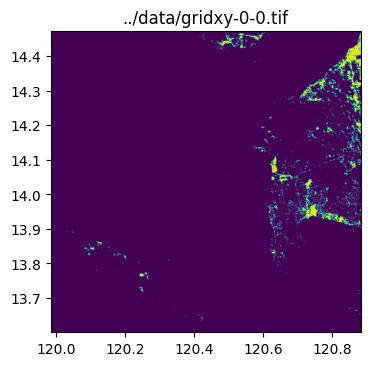

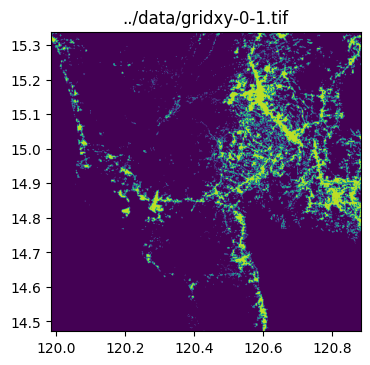

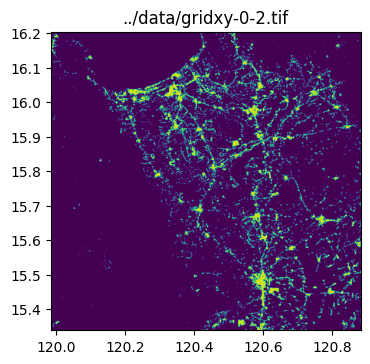

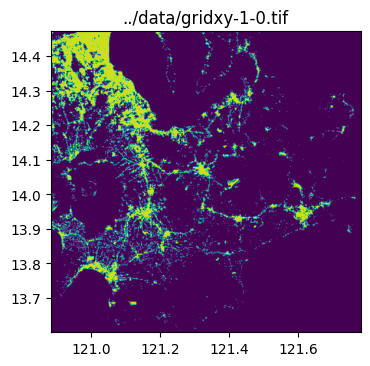

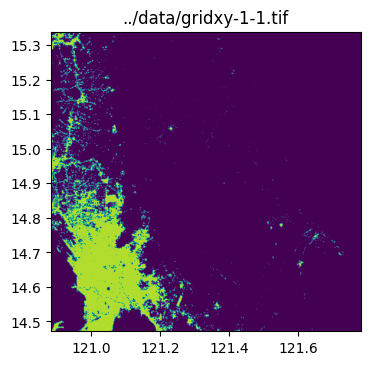

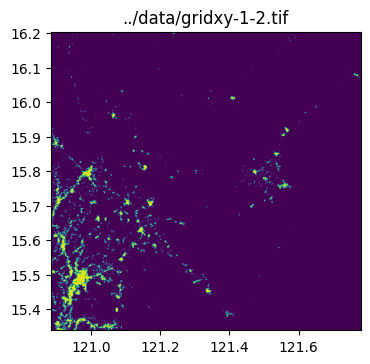

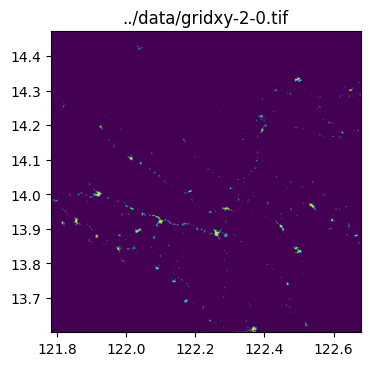

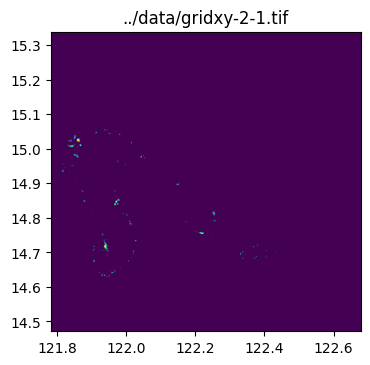

In [30]:
# no_test
for name in grid_gdf["name"]:
    image_path = output_folder / (name + ".tif")
    with rio.open(image_path) as dst:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.set_title(image_path)
        show(dst.read(1), cmap="viridis", ax=ax, transform=dst.transform)